<a target="_blank" href="https://colab.research.google.com/github/sonder-art/neuroscience/blob/main/30_pls.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Execute the next cells to install the necessary libraries in `Colab`

In [26]:
import os

# Set the environment variable
os.environ['SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL'] = 'True'
# Verify if it's set correctly
print(os.environ.get('SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL'))


In [27]:
!pip install py-ddspls
!pip install requests

In [28]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

In [29]:
import py_ddspls

## Subject demographics

In [30]:
demo_std_path = 'data/output/processed_demographics.csv'

Execute the cell below if you are on `Colab` if you are running this folder locally then there is no need for downloading the data.

In [31]:
demo_std_path = 'https://raw.githubusercontent.com/sonder-art/neuroscience/main/data/output/processed_demographics.csv'

In [32]:
demo_std = pd.read_csv(demo_std_path)
print('demographics',demo_std.shape)
demo_std.head()

demographics (50, 11)


,subject_id,sex,age,education,fhd,aud_1,pca_alcohol_1,pca_alcohol_2,pca_urgency,pca_behavior_1,pca_behavior_2
0,n001,1.128152,-0.888367,0.699854,1.333922,0.952270,-0.100724,-0.989391,-0.181554,0.860323,-0.486053
1,n002,-0.886405,-0.313992,0.408248,-0.302037,-0.724262,-0.419833,1.138460,-0.165535,2.591318,0.015633
2,n003,1.128152,-0.313992,0.408248,2.485751,-1.394874,-3.523414,0.629532,-0.337348,-0.754898,-1.578723
3,n004,-0.886405,0.834759,1.283066,-0.032745,-0.388955,0.582196,-0.970594,-0.551876,-2.408923,0.534127
4,n005,1.128152,-0.888367,-1.924599,-0.580235,-1.394874,-0.811180,-0.763278,-0.975593,0.941555,-0.055201


In [33]:
demo_names = demo_std.columns[1:]

## Subject brain vectors

Execute the cell below if you are on `Colab` if you are running this folder locally then there is no need for downloading the data.

In [34]:
import os
import requests
# Github Path
file_urls = ['https://github.com/sonder-art/neuroscience/raw/main/data/output/subject_brain_vectors.npy']
series_path = 'data/output/'

# Ensure the save folder exists
os.makedirs(series_path, exist_ok=True)

for url in file_urls:
    # Extract the file name
    file_name = url.split('/')[-1]
    
    # Full path for saving the file
    save_path = os.path.join(series_path, file_name)

    # Download and save the file
    response = requests.get(url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download {file_name}")


Downloaded subject_brain_vectors.npy


In [35]:
stackedVecs = np.load('data/output/subject_brain_vectors.npy')
stackedVecs.shape

(50, 54946)

## Partial Leas Squares (Sparse)

In [36]:
X, Y = stackedVecs, demo_std.iloc[:,1:]
print(f'X: {X.shape}')
#print(X.columns.values)
print(f'y: {Y.shape}')

X: (50, 54946)
y: (50, 10)


In [37]:
n_components = 4

In [38]:
lambd = 0.0
Xs = {0:X}

model_0 = py_ddspls.model.ddspls(Xs, Y, lambd=lambd, R=n_components, mode="reg", verbose=True)

y_loads_zero = model_0.model.v
x_loads_zero = model_0.model.u[0]

In [39]:
print(f'Y Loadings: {y_loads_zero.T.shape}')
print(f'X Loadings: {x_loads_zero.T.shape}')

Y Loadings: (4, 10)
X Loadings: (4, 54946)


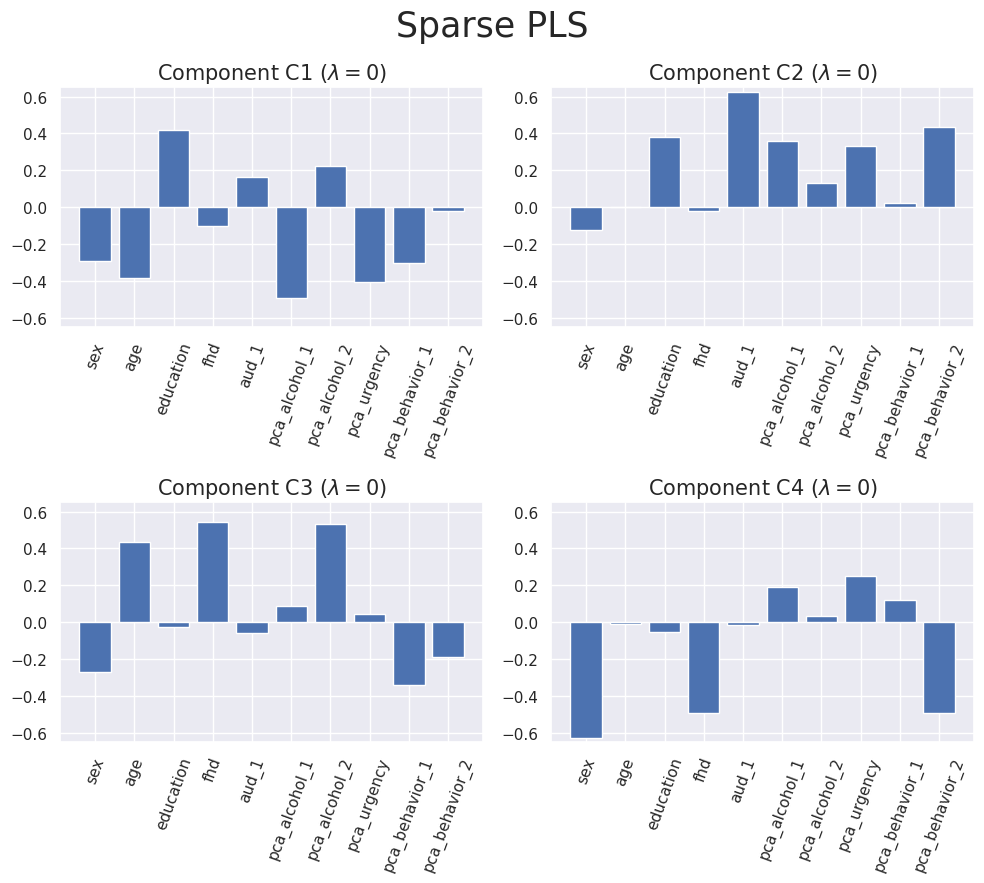

In [40]:
fig = plt.figure(figsize=(10,9))
plt.suptitle("Sparse PLS", fontsize=25)

for c in range(n_components):
    
    ax = fig.add_subplot(2, 2, c+1)
    ax.bar(Y.columns, y_loads_zero[:,c])
    plt.title(f'Component C{c+1} ($\lambda=0$)', fontsize=15)
    ax.set_ylim(-0.65, 0.65)
    ax.set_xticklabels(demo_names, rotation=70)

plt.tight_layout()

## Covariance

In [41]:
rc = []
rv = []
for component in range(n_components):
    
    y_vec = (Y@y_loads_zero[:,component])
    x_vec = (X@x_loads_zero[:,component])
    
    rcov = np.cov(x_vec, y_vec)[1,0]
    rcor = np.corrcoef(x_vec, y_vec)[1,0]
    
    if rcov < 0:
        rcov = -1*rcov
        rcor = -1*rcor
    
    rv.append(np.round(rcov,2))
    rc.append(np.round(rcor,2))

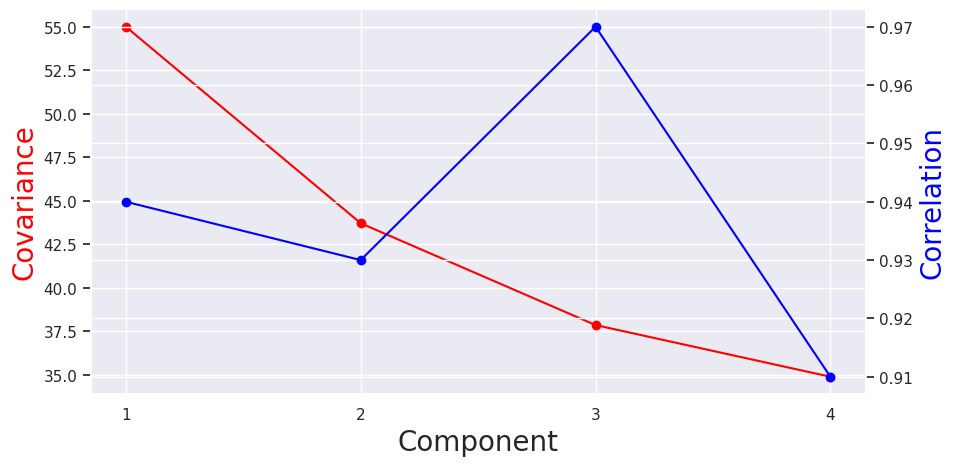

In [42]:
fig, ax = plt.subplots(figsize=(10,5))

ax.plot([1,2,3,4], rv, color="red", marker="o")
ax.set_xlabel("Component", fontsize = 20)
ax.set_ylabel("Covariance", color="red", fontsize=20)
ax.set_xticks([1,2,3,4])

ax2=ax.twinx()
ax2.plot([1,2,3,4], rc, color="blue",marker="o")
ax2.set_ylabel("Correlation", color="blue",fontsize=20)
ax2.set_xticks([1,2,3,4])
plt.show()

## Results

In [43]:
from utils.brain import matrix_from_vector

In [44]:
x_loads_matrix = []
for c in range(n_components):
    x_loads_matrix.append(matrix_from_vector(x_loads_zero[:,c], 332))
x_loads_matrix = np.array(x_loads_matrix)
x_loads_matrix.shape

(4, 332, 332)

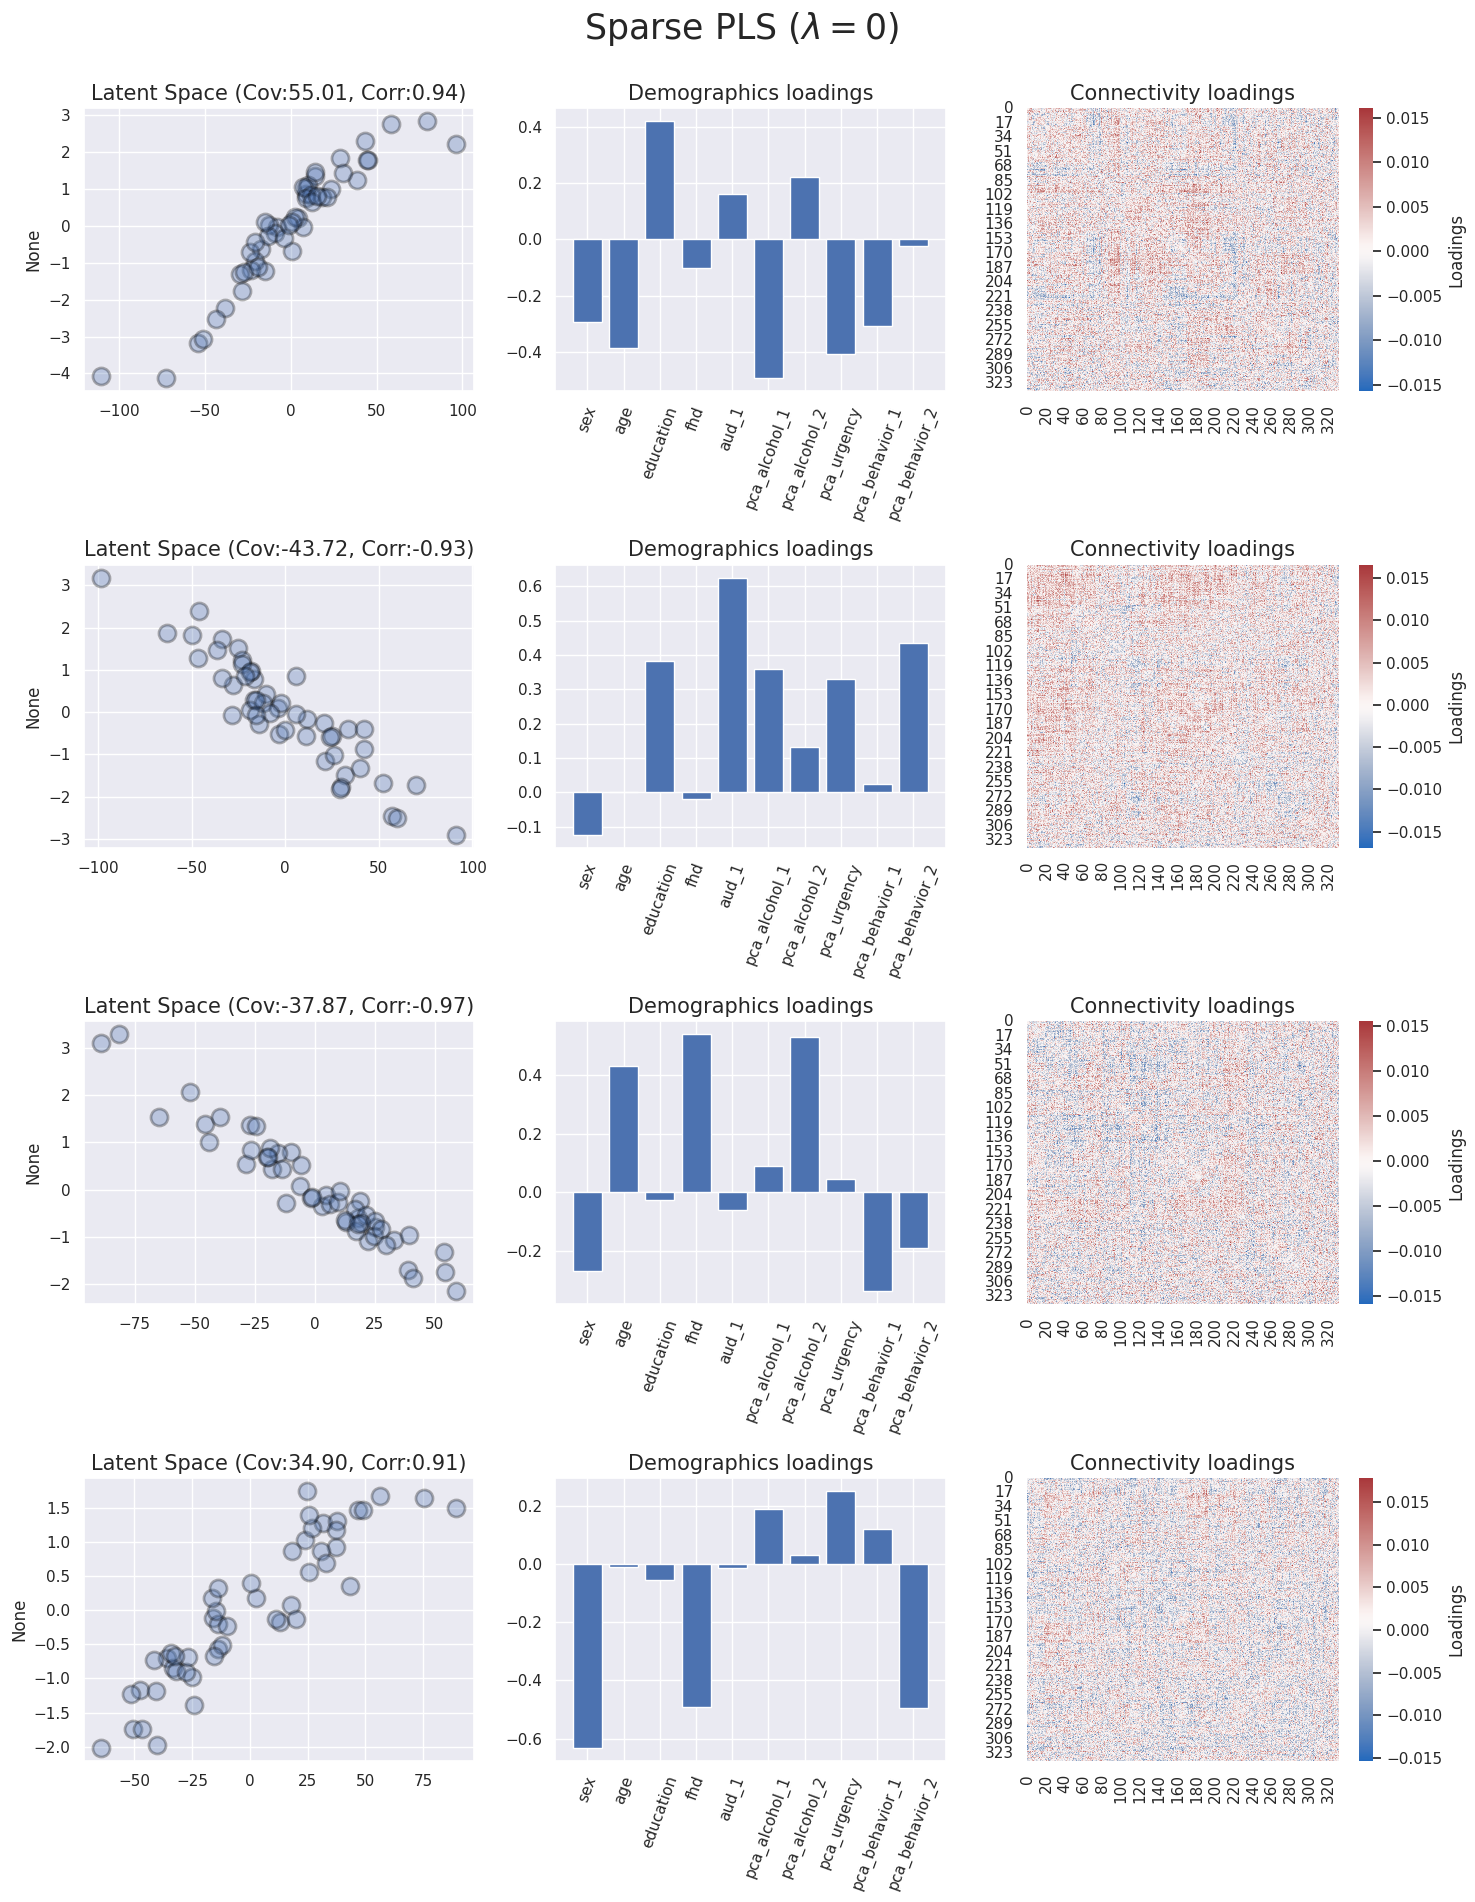

In [45]:
fig = plt.figure(figsize=(15,19))

n_rows, n_cols = 4, 3
for component in range(n_components):
    n_plot = (component+1)*3
    
    y_vec = (Y@y_loads_zero[:,component])
    x_vec = (X@x_loads_zero[:,component])
    
    rcov = np.cov(x_vec, y_vec)[1,0]
    rcor = np.corrcoef(x_vec, y_vec)[1,0]
    
    # SCATTERPLOT
    ax = fig.add_subplot(n_rows, n_cols, n_plot-2)
    plt.title(f'Latent Space (Cov:{rcov:.2f}, Corr:{rcor:.2f})', fontsize=15)
    sns.scatterplot(x=x_vec, y=y_vec, alpha=0.3, s=150, linewidth=2, edgecolor='black', ax=ax)
    
    # Y LOADING
    ax = fig.add_subplot(n_rows, n_cols, n_plot-1)
    ax.bar(Y.columns, y_loads_zero[:,component])
    plt.title(f'Demographics loadings', fontsize=15)
    #ax.set_ylim(-0.5, 0.5)
    ax.set_xticklabels(demo_names, rotation=70)
    
    # X LOADING
    ax = fig.add_subplot(n_rows, n_cols, n_plot)
    ax = sns.heatmap(x_loads_matrix[component,:,:], cbar_kws={'label': 'Loadings'}, cmap='vlag')
    plt.title(f'Connectivity loadings', fontsize=15)

plt.suptitle('Sparse PLS ($\lambda=0$)', fontsize=25, y=1)
plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()